<a href="https://colab.research.google.com/github/ccc-frankfurt/Practical_ML_SS21/blob/main/week04/RandomForest_san_francisco_crime_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forests and San Fancisco Crime dataset

Welcome to this week`s session. We will implement Random Forests and use it to predict the kind of crime using the San Francisco Crime dataset.

You can find the San Francisco Crime dataset and a corresponding tutorial challenge on Kaggle at https://www.kaggle.com/c/sf-crime#description

One possible solution to the challenge can be found at https://github.com/TobiasWeis/kaggle_sf_crime. We adapt it here.

The RandomForest implementation is based on fastai`s machine learning course (see http://course18.fast.ai/lessonsml1/lesson7.html for the lecture and for the code: https://github.com/fastai/fastai/blob/master/courses/ml1/lesson3-rf_foundations.ipynb ). The license for the RandomForest code can be found at: https://github.com/fastai/fastai/blob/master/LICENSE

In [ ]:
!pip install seaborn --upgrade 
!pip install pip install matplotlib==3.1.3

import time
import pandas as pd
import numpy as np
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import graphviz 

Requirement already up-to-date: seaborn in /usr/local/lib/python3.7/dist-packages (0.11.1)


## Revisiting the Titanic dataset 
Loading the Titanic dataset which you are already acquainted with.

In [ ]:
sns.set()
titanic = sns.load_dataset("titanic")
titanic = titanic.dropna(subset=["embarked", "embark_town"])
#print(titanic.info())
#print(titanic.describe())

In [ ]:
sex = pd.get_dummies(titanic["sex"], drop_first=True)
fare = titanic["fare"]
parch = titanic["parch"]
pclass = titanic["pclass"]
sibsp = titanic["sibsp"]

x = pd.concat([sex, fare, parch, pclass, sibsp], axis=1)
y = titanic["survived"].values
labels = ['not survived', 'survived']

In contrast to last weeks exercise where we converted our tabular data to Numpy matrices, this is not necessary here. Instead we can use Pandas' data frame directly and index the needed data with the "iloc" function. 

In [ ]:
perm = np.random.permutation(len(x))

split = 0.8

x_train, x_test = x.iloc[perm[:int(split*len(x))]], x.iloc[perm[int(split*len(x)):]]
y_train, y_test = y[perm[:int(split*len(y))]], y[perm[int(split*len(y)):]]

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(711, 5) (178, 5) (711,) (178,)


Define a function to compute the accuracy of the prediction.

In [ ]:
# this accuracy calculation will work only for 2 classes (!)
def accuracy(pred, y_target):
    threshold = 0.5
    y_target = y_target.squeeze()
    pred=pred.squeeze()
    
    # where boolean prediction mask and target match, there will be a 1, else 0
    return ((pred>=threshold)*y_target+(pred < threshold)*(1-y_target)).sum()/float(len(y_target))

## Introduction to sklearn`s **RandomForestClassifier** and **RandomForestRegressor**
First, we will classify, which Titanic passengers survived, using the RandomForestClassifier. Then, RandomForestRegressor will be used for the same task to exemplify that the **splitting metric**, as well as **leaf values** (classes vs. numbers) differs, but in principle the way the tree is grown stays the same.

In [ ]:
# define the RandomForestClassifier and fit the data (build 1 tree with max depth 2 and set the bootstrap parameter to False)
# when bootstrap is set to false, all the data are fed to every classifier
m = RandomForestClassifier(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
# predict the results for your train and test data
preds_train = m.predict(x_train)
preds_test = m.predict(x_test)

# calculate the accuracy
acc_train = accuracy(preds_train, y_train)
acc_test = accuracy(preds_test, y_test)

# print the results
print('train_acc: {0:4f}, test_acc: {1:4f}'.format(acc_train, acc_test))

train_acc: 0.793249, test_acc: 0.758427


**Graphviz ** is an open source graph visualization software: 
https://www.graphviz.org/, 
https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

711 440.0 271.0 250.0 63.0 187.0
gini_root: 0.471751, gini_left: 0.376992


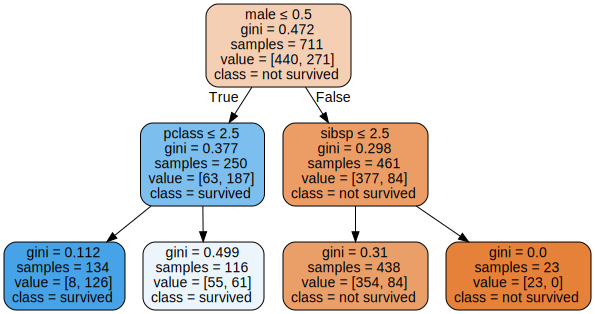

In [ ]:
# visualize the fitted tree to your train data
dot_data = tree.export_graphviz(m.estimators_[0], out_file=None, 
                         feature_names=x_train.columns,  
                         class_names=labels,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 

t = m.estimators_[0].tree_

n_samples = len(y_train)

# the first zero indicates the first node (then the root left ones, and root right ones) 
# the second can be ignored, the third one is the non-survived/survived value
n_samples_ns = t.value[0][0][0] # number of not survived before first split
n_samples_s = t.value[0][0][1] # number of survived before first split

n_samples_left_ns = t.value[1][0][0]
n_samples_left_s = t.value[1][0][1]

n_samples_left = n_samples_left_ns + n_samples_left_s

# compare the values with the graph below
print(n_samples,n_samples_ns,n_samples_s,n_samples_left,n_samples_left_ns,n_samples_left_s)

# compute the gini impurity for the root node and its left child
gini_root = 1. - (n_samples_ns/n_samples)**2 - (n_samples_s/n_samples)**2
gini_left = 1. - (n_samples_left_ns/n_samples_left)**2 - (n_samples_left_s/n_samples_left)**2

print('gini_root: {0:2f}, gini_left: {1:3f}'.format(gini_root, gini_left))

graph

Let us change the splitting criterion from **Gini** to **Information Gain**.

train_acc: 0.774965, test_acc: 0.747191
root_entropy:0.958852, left_entropy:0.736894, right_entropy:1.000000
gain: 0.065797, intrinsic_information: 0.974610, gain_ratio: 0.067511


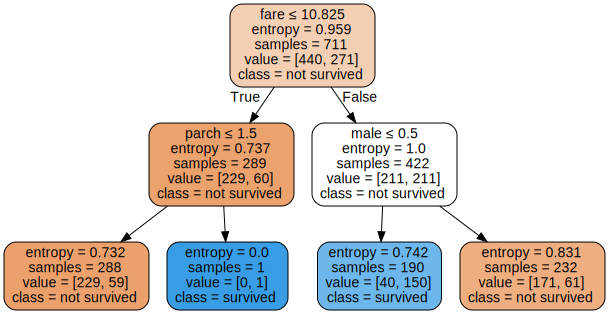

In [ ]:
# define the RandomForestClassifier with entropy as the splitting criterion, 1 tree, max_depth=2 and bootstrap=False
# and fit the data
m = RandomForestClassifier(n_estimators=1, criterion="entropy", max_depth=2, bootstrap=False)
m.fit(x_train, y_train)

# predict the results for your train and test data
preds_train = m.predict(x_train)
preds_test = m.predict(x_test)

# calculate the accuracy
acc_train = accuracy(preds_train, y_train)
acc_test = accuracy(preds_test, y_test)

# print the results
print('train_acc: {0:4f}, test_acc: {1:4f}'.format(acc_train, acc_test))

# prepare the variables for the entropy gain calculation
t = m.estimators_[0].tree_
n_samples = float(len(y_train))

n_samples_ns = t.value[0][0][0] # number of not survived before first split
n_samples_s = t.value[0][0][1] # number of survived before first split

n_samples_lns = t.value[1][0][0] # number of not survived after first split for the first node
n_samples_ls = t.value[1][0][1]

n_samples_left = float(n_samples_lns + n_samples_ls)

# to get the root right nodes directly, use children_right
n_samples_rns = t.value[t.children_right][0][0][0]
n_samples_rs = t.value[t.children_right][0][0][1]

n_samples_right = float(n_samples_rns + n_samples_rs)

# calculate the entropy gain

entropy_root = -(n_samples_ns/n_samples)*np.log2(n_samples_ns/n_samples) - (n_samples_s/n_samples)*np.log2(n_samples_s/n_samples)

entropy_left = -(n_samples_lns/n_samples_left)*np.log2(n_samples_lns/n_samples_left) - (n_samples_ls/n_samples_left)*np.log2(n_samples_ls/n_samples_left)
entropy_right = -(n_samples_rns/n_samples_right)*np.log2(n_samples_rns/n_samples_right) - (n_samples_rs/n_samples_right)*np.log2(n_samples_rs/n_samples_right)

print('root_entropy:{0:4f}, left_entropy:{1:4f}, right_entropy:{2:4f}'.format(entropy_root, entropy_left, entropy_right))

gain = entropy_root - (n_samples_left/n_samples)*entropy_left - (n_samples_right/n_samples)*entropy_right
intrinsic_information = -(n_samples_left/n_samples)*np.log2(n_samples_left/n_samples)-(n_samples_right/n_samples)*np.log2(n_samples_right/n_samples)
gain_ratio = gain/intrinsic_information

print('gain: {0:2f}, intrinsic_information: {1:3f}, gain_ratio: {2:3f}'.format(gain, intrinsic_information, gain_ratio))

# visualize the fitted tree to your train data
dot_data = tree.export_graphviz(m.estimators_[0], out_file=None, 
                         feature_names=x_train.columns,  
                         class_names=labels,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

Let us repeat the same process we went through for the **RandomForestClassifier**, for the **RandomForestRegressor**: 

1. define the regressor
2. fit the data
3. calculate the accuracy
4. visualize the tree graph for the first tree




In [ ]:
# define the RandomForestRegressor and fit the data
m = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_train, y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# predict the results for your train and test data
preds_train = m.predict(x_train)
preds_test = m.predict(x_test)

# calculate the accuracy

acc_train = accuracy(preds_train, y_train)
acc_test = accuracy(preds_test, y_test)

# print the results
print('train_acc: {0:4f}, test_acc: {1:4f}'.format(acc_train, acc_test))

train_acc: 0.793249, test_acc: 0.758427


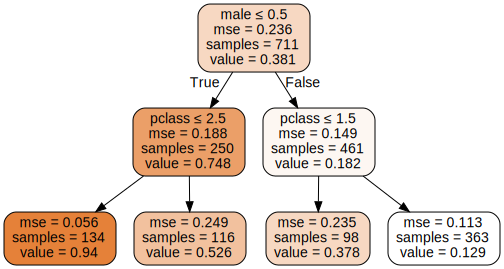

In [ ]:
# visualize the fitted tree to your train data
dot_data = tree.export_graphviz(m.estimators_[0], out_file=None, 
                         feature_names=x_train.columns,  
                         class_names=labels,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

## RandomForest from scratch. 

What we need are 2 classes:

1. TreeEnsemble class which combines trees.
2. DecisionTree class which grows single trees given subsets of data.

In [ ]:
# the TreeEnsemble class is adapted from fastai (the seed has been taken out, comments added, 
# sample_sz, min_leaf variable name changed, added max_depth parameter
class TreeEnsemble():
    """
    A class that builds n estimators (decision trees) and averages their prediction.
    """
    
    def __init__(self, x, y, n_trees, n_samples, min_sample_leaf=5, max_depth=2):
        """
        Initialize the TreeEnsemble
        
        Args:
          x (pandas DataFrame): input data of dimensions (num_instances, num_features)
          y (array of targets): numbers for regression or categories for classification
          n_trees (int): number of decision trees to create
          n_samples (int): number of data samples to use for each tree
          min_sample_leaf (int): minimal number of data instances, in order to split the node
        """
        
        self.x = x
        self.y = y
        self.n_samples = n_samples 
        self.min_sample_leaf = min_sample_leaf
        self.max_depth = max_depth
        
        # create n_trees amout of trees and save them in a list
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        # create the indices of data instances to take: 1. permute data indices, 2. take first n_samples
        idxs = np.random.permutation(len(self.y))[:self.n_samples]
        
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], idxs=np.array(range(self.n_samples)), 
                            min_sample_leaf=self.min_sample_leaf, max_depth=self.max_depth)
    
    def predict(self, x):
        """
        This function calculates the mean prediction over the list of decision trees

        Args:
          x (pandas DataFrame): input data of dimensions (num_instances, num_features)

        Returns:
          array of floats of length num_instances: the mean prediction over decision trees for each data instance
        """
        
        # given that DecisionTree class also has a predict(x) function, calculate the mean prediction for all trees
        # hint:the mean has to be calculated over a specific axis
        return np.mean([t.predict(x) for t in self.trees], axis=0)

Test the TreeEnsemble class with dummy data (only a basic test that the class does not throw errors upon definition)

In [ ]:
# create a dummy DecisionTree class
class DecisionTree():
    def __init__(self, x, y, idxs, min_sample_leaf=5, max_depth=2):
        pass
    
    def predict(self, x):
      # dummy output
      return [1., 2., 3.]

In [ ]:
# test the TreeEnsemble class: the dummy output of DecisionTree suggests 3 data instances, 
# thus, ens.predict should return the same (think why - how do you calculate the mean?)
ens = TreeEnsemble(x_train, y_train, n_trees=5, n_samples=int(0.5*len(x_train)))

if not sum(ens.predict(x_train)) == 6:
    raise ValueError("The tree ensemble implementation does not seem to be correct")

Let us now create the **DecisionTree** class.

In [ ]:
# the DecisionTree class is adapted from fastai 
# (comments added, variable name (min_leaf) changed, find_varsplit and find_better_split changed)
class DecisionTree():
    def __init__(self, x, y, idxs, min_sample_leaf=5, max_depth=5, curr_depth=0):
        """
        Initialize the DecisionTree
        
        Args:
          x (pandas DataFrame): input data of dimensions (num_instances, num_features)
          y (array of targets): numbers for regression or categories for classification
          indxs (array): indices of data instances which belong to this node of the decision tree
          min_sample_leaf (int): minimal number of data instances, in order to split the node
          max_depth (int): maximum depth of the tree
          curr_depth (int): depth of the given node (0 for root, 1 for its children etc.)
        """
        
        self.x = x
        self.y = y
        self.idxs = idxs
        self.min_sample_leaf = min_sample_leaf
        
        # n - number of data instances in the tree/node, c - number of features
        self.n,self.c = len(idxs), x.shape[1]
        
        # the predicted class or regressed value for the leaf
        self.val = float(np.mean(y[idxs]))
        # the criterion (entropy, mse) value at this node
        # it is not identical to the score, 
        # as the score is the weighting of the criterions of node and children
        self.criterion_val = self.split_criterion(y[idxs])
        
        # the splitting score given the splitting criterion
        self.score = float('inf')
        self.var_idx = None # index of the feature/variable to split on
        self.split = None # the split value
        
        self.max_depth = max_depth
        self.depth = curr_depth
                
        if self.depth < self.max_depth: self.find_varsplit()
        
    def find_varsplit(self):
        # for each feature, check whether it provides the best split
        # set the var_idx, score and split value
        for i in range(self.c): 
            self.binary_split(i)
            
        # the criteria for splitting the node are not met - it will be a leaf
        if self.score == float('inf'): return
        
        # get the values of the column along which the split is about to be done
        x = self.x.values[self.idxs,self.var_idx]
        # get the indices of the data instances to the left and right
        # nonzero returns a tuple of arrays, one for each dimension, row-major, C-style
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        
        # create the left and right decision trees, pay attentio to select from self.idxs only the correct one
        # hint: use lhs and rhs above
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs], max_depth=self.max_depth, curr_depth=self.depth+1)
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs], max_depth=self.max_depth, curr_depth=self.depth+1)

    def binary_split(self, var_idx):
        # get the column of all x values for a certain feature
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]

        # go through all data instances and check whether to split on that value
        for i in range(self.n):
            # calculate boolean masks which split the feature along a certain value
            lhs = x<=x[i]
            rhs = x>x[i]
            
            # check that both right and left node children have at least min_samples_leaf data instances
            # if not - the score will stay infinity, so the node will remain unsplitted
            if rhs.sum()<self.min_sample_leaf or lhs.sum()<self.min_sample_leaf: continue
            curr_score = self.split_score(lhs, rhs, y)
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,x[i]

    def split_score(self, lhs, rhs, y):
        '''
        This function calculates the weighted score for the split.
        
        Args:
          lhs (array of booleans): the mask for which instances would split to the left
          rhs (array of booleans): the mask for which instances would split to the right
          y (array of numbers): the class or value to predict
        
        '''
        
        lhs_var = self.split_criterion(y[lhs])
        rhs_var = self.split_criterion(y[rhs])
        
        # weighted (by the number of examples right and left) variance
        curr_score = lhs_var*lhs.sum() + rhs_var*rhs.sum()
        return curr_score
      
    def split_criterion(self, y):
        return y.var()
    
    # a property decorator means that you can omit brackets when you call this function
    # for example in __repr__ self.split_name
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = "n: {0}; val:{1:4f}; mse/entropy/gini:{2:4f}; depth:{3}".format(self.n, self.val, self.criterion_val, self.depth) 
        
        if not self.is_leaf:
            s += "; score:{0:4f}; split:{1}; var:{2}".format(self.score,self.split,self.split_name)
        return s

    def predict(self, x):
        # for each data instance (a row of features), make a prediction 
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        # if the value of the feature for xi is <= self.split (the splitting value), then t = self.lhs else self.rhs
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [ ]:
ens = TreeEnsemble(x_train, y_train, 1, len(y_train), max_depth=2)
print(ens.trees[0])
print(ens.trees[0].lhs)
print(ens.trees[0].lhs.lhs)
print(ens.trees[0].lhs.rhs)
print(ens.trees[0].rhs)

n: 711; val:0.381153; mse/entropy/gini:0.235875; depth:0; score:115.818143; split:0.0; var:male
n: 250; val:0.748000; mse/entropy/gini:0.188496; depth:1; score:36.444802; split:2.0; var:pclass
n: 134; val:0.940299; mse/entropy/gini:0.056137; depth:2
n: 116; val:0.525862; mse/entropy/gini:0.249331; depth:2
n: 461; val:0.182213; mse/entropy/gini:0.149011; depth:1; score:63.945213; split:1.0; var:pclass


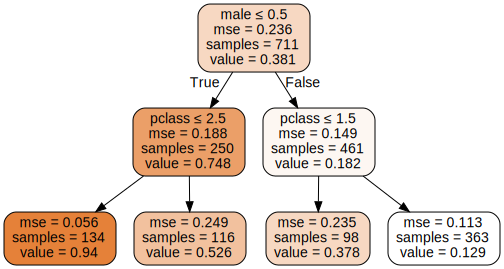

In [ ]:
# compare the calculated regressed values to the random forest

m = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_train, y_train)

# visualize the fitted tree to your train data
dot_data = tree.export_graphviz(m.estimators_[0], out_file=None, 
                         feature_names=x_train.columns,  
                         class_names=labels,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph

Exchange the splitting criterion of the DecisionTree from **mse** to **entropy**, create sklearn's **RandomForestClassifier** and compare the entropies

In [ ]:
def split_criterion(self, y):
    entropy = 0
    eps = 1e-15
    # yi is the class value, e.g. 0,1,2 if there are 3 classes, 0, 1 in our case
    for yi in np.unique(y):
        mask = y==yi
        pi = mask.sum()/len(y)
        entropy += -pi*np.log2(pi+eps)
    return entropy

In [ ]:
# exchange the earlier split_criterion function (mse) with the one above
DecisionTree.split_criterion=split_criterion

In [ ]:
ens = TreeEnsemble(x_train, y_train, 1, len(y_train), max_depth=2)
print(ens.trees[0])
print(ens.trees[0].lhs)
print(ens.trees[0].lhs.lhs)
print(ens.trees[0].lhs.rhs)
print(ens.trees[0].rhs)

n: 711; val:0.381153; mse/entropy/gini:0.958852; depth:0; score:519.344075; split:0.0; var:male
n: 250; val:0.748000; mse/entropy/gini:0.814433; depth:1; score:159.494715; split:2.0; var:pclass
n: 134; val:0.940299; mse/entropy/gini:0.326259; depth:2
n: 116; val:0.525862; mse/entropy/gini:0.998069; depth:2
n: 461; val:0.182213; mse/entropy/gini:0.684893; depth:1; score:295.545163; split:1.0; var:pclass


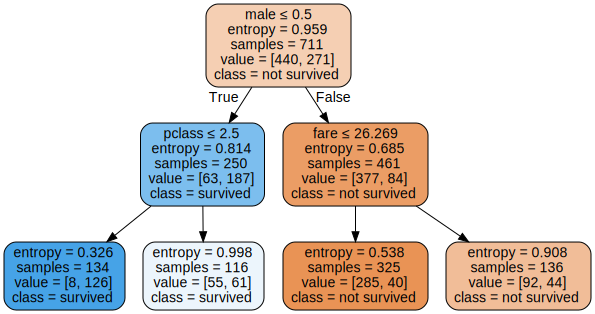

In [ ]:
# since RandomForestClassifier selects randomly m best features to split on, we fix the seed
# the random split on a subset of features serves the aim of reducing overfitting (variance) of the model
# for more on bias-variance trade-off check ou:
# https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229
# if the split is still long different variables than above, then comment the next line out and run the cell a couple of times...
np.random.seed(1936483610)

m = RandomForestClassifier(n_estimators=1, criterion='entropy', max_depth=2, bootstrap=False)
m.fit(x_train, y_train)

# visualize the fitted tree to your train data
dot_data = tree.export_graphviz(m.estimators_[0], out_file=None, 
                         feature_names=x_train.columns,  
                         class_names=labels,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 

graph

## San Francisco Crime
We will now apply our new knowledge about random forests to a new dataset: 
https://www.kaggle.com/c/sf-crime#description.
So, go to the kaggle website, download the data, then click on the upload button in colab and upload it.

In [ ]:
!pip install wget
import wget

# download the data
data = wget.download('https://github.com/TobiasWeis/kaggle_sf_crime/raw/master/data/kaggle_data.zip')

In [ ]:
import zipfile

# extract the zipfile
zip_ref = zipfile.ZipFile('kaggle_data.zip', 'r')
zip_ref.extractall('.')
zip_ref.close()

In [ ]:
"""
    Load the datafiles (assuming its in the same directory as this notebook)
    
    Transform the features:
    - Extract datetime-features using pandas
    - Transform string variables to integers (same string -> same integer)
    - Calculate whether an address is a street corner by searching for the "/" character
    
"""
def load_csv(fname):
    df = pd.read_csv(fname, parse_dates=['Dates'])

    df['Hour'] = df.Dates.dt.hour
    df['Month'] = df.Dates.dt.month
    df['Year'] = df.Dates.dt.year
    df['DayOfWeek'] = df.Dates.dt.dayofweek
    df['DayOfYear'] = df.Dates.dt.dayofyear

    # add an attribute PdDistrict_num, which transforms PdDistrict-strings to integers, 
    # e.g. 'NORTHERN' to 4
    df['PdDistrict_num'] = df.PdDistrict.astype('category').cat.codes.astype('int')

    # if there is a / in the address, then it is a street corner
    df['StreetCorner'] = df['Address'].apply(lambda x: 1 if '/' in x else 0)
    
    # check for the outliers in the position, e.g. north pole instead of san francisco
    df = df[np.abs(df.X-df.X.mean())<=(3*df.X.std())]
    
    return df
    
df = load_csv('train.csv')
df_test = load_csv('test.csv')

In [ ]:
# visualize the available attributes of the dataset and their form
df[:5]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Hour,Month,Year,DayOfYear,PdDistrict_num,StreetCorner
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,2,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,23,5,2015,133,4,1
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,2,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,23,5,2015,133,4,1
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,2,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,23,5,2015,133,4,1
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,2,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,23,5,2015,133,4,0
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,2,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,23,5,2015,133,5,0


In [ ]:
# check how many different crime categories are present in the dataset
unique_categories = df["Category"].unique()
print('number of crime categories to predict:')
len(unique_categories)

number of crime categories to predict:


39

In [ ]:
# add an attribute Category_num with numerical values for categories instead of string names
df['Category_num']=df['Category'].astype('category').cat.codes
# the string array assigns numerical categories to their string labels
categories = df['Category'].astype('category').cat.categories

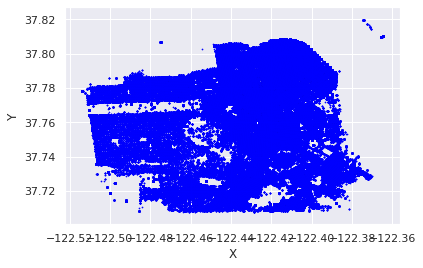

In [ ]:
# visualize the locations of all crime categories

df.plot.scatter(x='X',y='Y',s=0.5,c='blue')

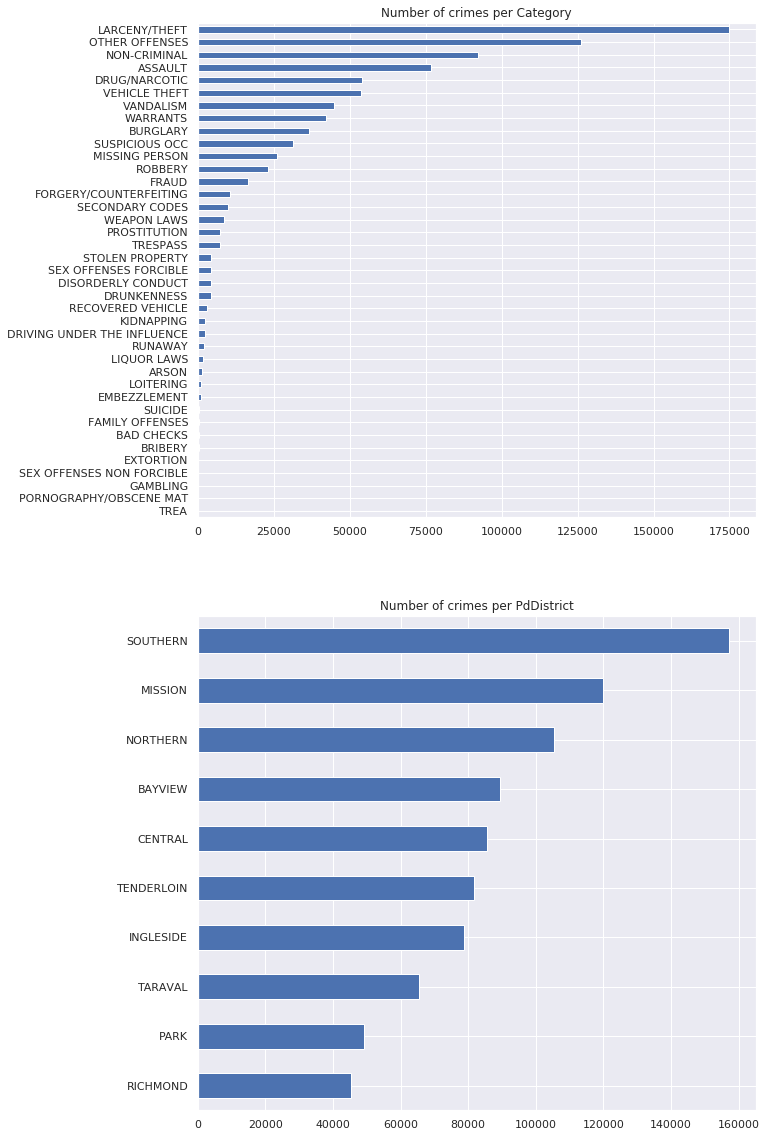

In [ ]:
# visualize the number of crimes per Category and PdDistrict
# hint: https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html

import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10,20))
fig.add_subplot(211)
df["Category"].value_counts(ascending=True).plot(kind="barh", title="Number of crimes per Category")
fig.add_subplot(212)
df["PdDistrict"].value_counts(ascending=True).plot(kind="barh", title="Number of crimes per PdDistrict")


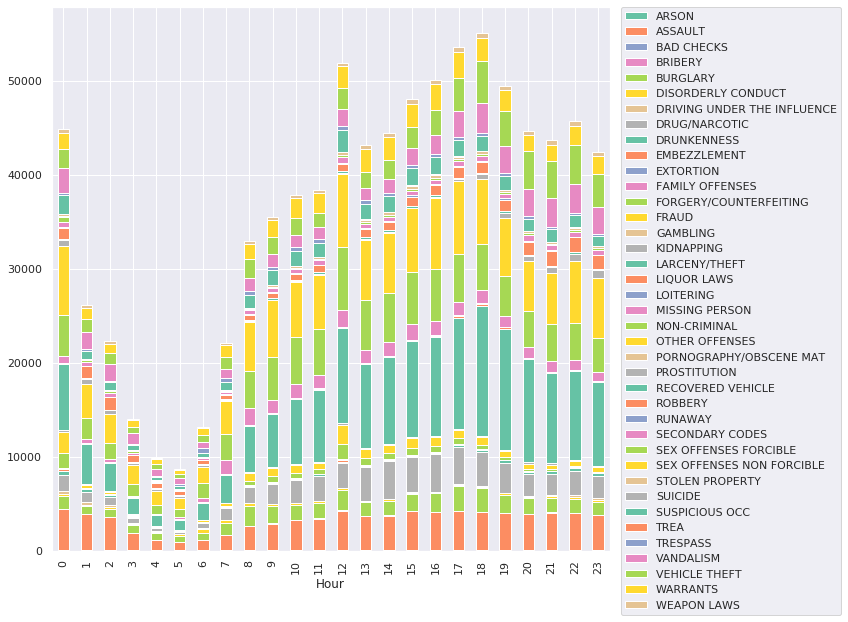

In [ ]:
# visualize the relationship between the hour at which the crime has been committed and the crime category
import seaborn as sns

by_param = df.groupby(['Hour', 'Category'])
# compute the sizes (number of elements) for the grouped data
table = by_param.size()
d2table = table.unstack()
d2table.plot(kind='bar', stacked='True',figsize=(10,10),color=sns.color_palette('Set2', len(np.unique(df.Category))))
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

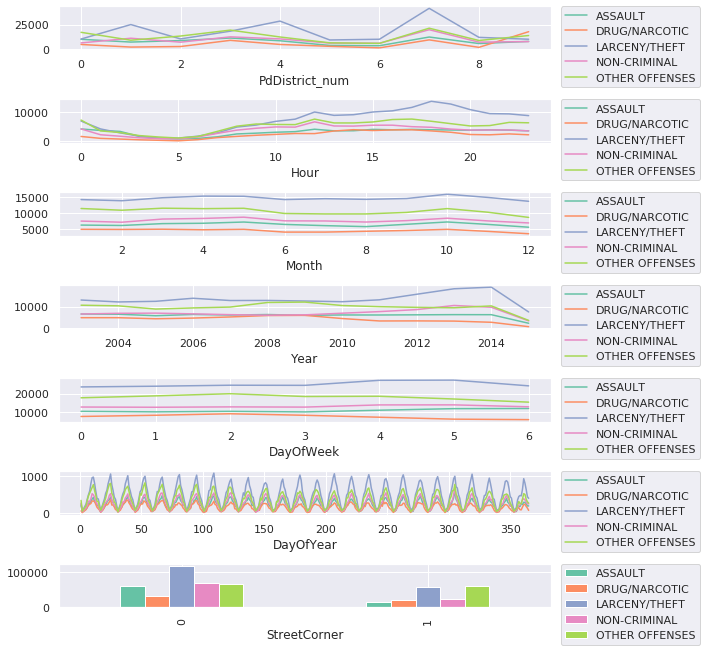

In [ ]:
import math
top_cats = ["LARCENY/THEFT", "OTHER OFFENSES", "NON-CRIMINAL", "ASSAULT", "DRUG/NARCOTIC"]
fig = plt.figure()
features = ["PdDistrict_num", "Hour", "Month", "Year","DayOfWeek", "DayOfYear", "StreetCorner" ]

nrows = 8
ncols = 1

for i,feat in enumerate(features):
    ax = fig.add_subplot(nrows, ncols, i+1)
    
    by_param = df[df.Category.isin(top_cats)].groupby([feat, 'Category'])
    table = by_param.size()
    d2table = table.unstack()
    
    if feat == 'StreetCorner':
        d2table.plot(ax=ax, figsize=(10,10), kind='bar', color=sns.color_palette('Set2', len(np.unique(df.Category))))
    else:
        d2table.plot(ax=ax, figsize=(10,10), color=sns.color_palette('Set2', len(np.unique(df.Category))))
    plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

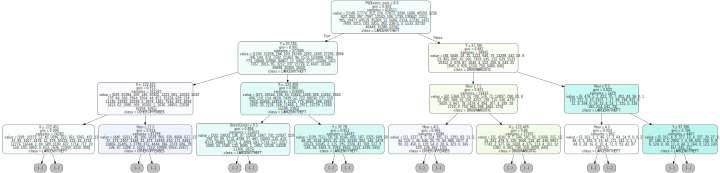

In [ ]:
'''
Apply previously acquired knowledge to the given data, to summarize:
1. Split the train data into train and test (the test subset is used to validate the results)
2. Choose features on which to train and get the data from those features
3. train a RandomForestClassifier (to speed up, restrict max_depth to e.g. 5)
4. visualize the graph
5. check the accuracy of the predictions on the X_test

Modify the procedure to incorporate log loss:
1. use another prediction function instead of clf.predict(), 
  which gives you class probabilities instead of a fixed class label 
2. instead of the accuracy, compute log_loss 
  (hint: use https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)
'''

import pydotplus

# select 75 percent of data as train and 25 as test
df['train'] = np.random.uniform(0,1,len(df)) <= .75
train, test = df[df.train], df[~df.train]

# use some features to test, for example
features = ["X", "Y", "Hour", "StreetCorner", "DayOfWeek", "PdDistrict_num"]

# define x_train, y_train, x_test, y_test
x_train = train[features]
y_train = train.Category_num

x_test = test[features]
y_test = test.Category_num

clf = RandomForestClassifier(n_estimators=15, max_depth=10, n_jobs=4)
clf.fit(x_train, y_train)
preds = clf.predict(x_test)

import graphviz 
dot_data = tree.export_graphviz(clf.estimators_[0], out_file=None, 
                         max_depth=3,
                         feature_names=features,  
                         class_names=categories,  
                         filled=True, rounded=True,  
                         special_characters=True)  
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"10,10!"')
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

6. check the accuracy and the logarithmic loss of the predictions on the x_test,
for the comparison of the two, check out: http://wiki.fast.ai/index.php/Log_Loss,
check out also http://cs229.stanford.edu/proj2016/report/HaleLiu-SanFranciscoCrimeClassification.pdf, who have, among other thins, tried logistic regression to solve the challenge ;)

Is the accuracy value that you see high or low? Why do you think this is so?


In [ ]:
preds = clf.predict(x_test)
#pd.crosstab(test.Category, labels[preds], rownames=['Actual categories'], colnames=['Predicted categories'] )

from sklearn.metrics import accuracy_score
# calculate the accuracy for the test data
# hint: you need preds - predicted categories, as well as the ground truth categories
accuracy = accuracy_score(y_test, preds, normalize=True)

# instead of the category itself, set preds to the predicted probabilities for each class
preds = clf.predict_proba(x_test)

# why does preds has this shape?
print('shape of predict_proba(x_test)')
print(preds.shape)

from sklearn.metrics import log_loss
# calculate logistic loss or cross-entropy loss, set normalize=True
# the base of the logarithm for this function is e (natural logarithm)
log_loss = log_loss(y_test, preds, normalize=True)

print('accuracy: {0:1f}, log_loss: {1:2f}'.format(accuracy, log_loss))

shape of predict_proba(x_test)
(219460, 39)
accuracy: 0.264891, log_loss: 2.438413


In [ ]:
# for comparison reasons, fill predictions with 1./num_classes and compute the log_loss outcome
# this tells you what the log_loss is when each class is equally probable 
import numpy as np

num_classes = len(df.Category.unique())
preds = np.full((len(test),num_classes),1./num_classes)

from sklearn.metrics import log_loss
log_loss(y_test, preds, normalize=True)

3.6635616461296463

In [ ]:
"""
    Lets define the classifiers we want to test,
    as well as the subsets of features we are interested in
"""
classifiers = [
                tree.DecisionTreeClassifier(random_state=1337),
                RandomForestClassifier(random_state=1337, n_estimators=10)
                ]

# select your feature sets to test, e.g. ["X", "Y"]

feature_sets = [
                ["X", "Y"],
                ["X", "Y", "Hour"],
                ["X", "Y", "Hour", "StreetCorner", "DayOfWeek"],
                ['X','Y','PdDistrict_num']
               ]

In [ ]:
"""
    First try: run the classifiers with their default parameters on all feature sets
               using a basic train/test split of the data
    Hint #1: use https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    Hint #2: do not forget to stratify based on df.Category
"""

for clf in classifiers:
    for features_to_use in feature_sets:
        # split df (the train set) into train and test(validation), compute prediction and evaluate log_loss
        x_train, x_test, y_train, y_test = train_test_split(df[features_to_use], df.Category_num, stratify=df.Category_num, train_size=0.8, test_size=0.2)
        clf.fit(x_train, y_train)
        preds = clf.predict_proba(x_test)
        print(clf.__class__.__name__," on Feature set ",features_to_use,": ",log_loss(y_test, preds))
    print

DecisionTreeClassifier  on Feature set  ['X', 'Y'] :  6.173639911441525
DecisionTreeClassifier  on Feature set  ['X', 'Y', 'Hour'] :  16.505848141079653
DecisionTreeClassifier  on Feature set  ['X', 'Y', 'Hour', 'StreetCorner', 'DayOfWeek'] :  21.749173432963858
DecisionTreeClassifier  on Feature set  ['X', 'Y', 'PdDistrict_num'] :  6.235597831951954
RandomForestClassifier  on Feature set  ['X', 'Y'] :  5.915083602650245
RandomForestClassifier  on Feature set  ['X', 'Y', 'Hour'] :  12.869947082236747
RandomForestClassifier  on Feature set  ['X', 'Y', 'Hour', 'StreetCorner', 'DayOfWeek'] :  14.574183312860956
RandomForestClassifier  on Feature set  ['X', 'Y', 'PdDistrict_num'] :  5.957882505765794


In [ ]:
"""
    Observations:
        - RandomForrest generally performed better than the DecisionTree
        - Prediction-quality got less with increasing number features using the default classifier parameters
        
    Intuition: Curse of dimensionality, our models are not complex enough
    
    Lets search over additional hyperparameters that might help:
    ( if we have absolutely no clue about how the model works, 
      look up possible model-parameters in the sklearn-documentation,
      spend some time enumerating coarse parameter ranges that work using gridsearch )
      
    In this case, we have an intuition about what might work, so we can restrict the parameter space:
    - evaluate only RandomForrest (was generally better) to save some time
    - deeper trees will probably allow us to handle more feature combinations
    - min_samples_leaf might counter overfitting
    - num_estimators (for RandomForrests) will create more trees
    
"""
param_dict_rf = {
                "max_depth": [3,6],
                "min_samples_leaf" : [30, 35, 50],
                "n_estimators" : [10, 15, 20],
                }

for features_to_use in feature_sets:
    ss = time.time()
    # use RandomizedSearchCV with neg_log_loss as the scoring function
    # and RandomForestClassifier, give it param_dict_rf as param_distributions
    # set n_iter = 10
    random_search = RandomizedSearchCV(RandomForestClassifier(random_state=1337, n_jobs=4), 
                                       param_distributions=param_dict_rf, 
                                       n_iter=1, 
                                       scoring='neg_log_loss',
                                       cv=3
                                       )

    random_search.fit(df[features_to_use], df.Category_num)
    print("==================")    
    print("Took ", time.time() - ss)
    print(random_search.best_estimator_)
    print(-random_search.best_score_)
    print(features_to_use)

Took  34.80765151977539
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=35, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=4,
                       oob_score=False, random_state=1337, verbose=0,
                       warm_start=False)
2.545898085094515
['X', 'Y']
Took  27.54790472984314
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weigh

In [ ]:
"""
    Optional:
    Create submission file using the best classifier
    This time we fit on the complete training set.
    Compress the resulting csv-file using zip before uploading
"""
be = random_search.best_estimator_
use_these_features = ['X', 'Y', 'Hour', 'StreetCorner', 'DayOfWeek'] # adapt this to your best feature combination

be.fit(df[use_these_features], df.Category_num)
submission_preds = be.predict_proba(df_test[use_these_features])
submission = pd.DataFrame(submission_preds, columns=categories)
submission.to_csv('submission.csv', index=True, index_label='Id')